In [430]:
import mne
import matplotlib.pyplot as plt
from mne.channels import make_standard_montage
from mne_realtime import LSLClient, MockLSLStream, RtEpochs
import numpy as np
import pywt
import pickle

raw_each = [0] * 6

for i in range(0,6):
    raw_each[i] = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\hand"+ str(i) +"_new.edf",preload = True)

# raw_edf = mne.concatenate_raws(raw_each)
raw_edf = mne.concatenate_raws([raw_each[4]])
# raw_edf = mne.io.read_raw_edf("C:\git\Senior_Thesis\DataSet\Convert_data\MI_execution.edf", preload=True)

eeg1 = raw_edf.copy().filter(l_freq=1.0, h_freq=30.0, method = 'iir', iir_params= {"order": 5, "ftype":'butter'})
# eeg1 = raw_edf.copy().filter(l_freq=0.075, h_freq=3.0, method = 'fir')
eeg1 = eeg1.copy().set_eeg_reference(ref_channels="average")

eeg1= eeg1.pick(["Fz","C3", "Cz", "C4","Pz",'PO7','PO8'])
# eeg1= eeg1.pick_channels(["C3", "Cz", "C4"])
events, event_dict = mne.events_from_annotations(eeg1)
combine_epochs = mne.Epochs(eeg1, events, 
        tmin=-2.0,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax=4.0,    # final timestamp (10 means set epoch duration 10 second)
        event_id=event_dict,
        preload = True,
        event_repeated='drop'
    )

combine_epochs = combine_epochs.copy().crop(tmin=0.1, tmax=2.1)

Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand0_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand1_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand2_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand3_new.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 279249  =      0.000 ...  1116.996 secs...
Extracting EDF parameters from C:\git\Senior_Thesis\DataSet\Convert_data\hand4_n

In [431]:
combine_epochs.event_id

{'OVTK_GDF_Cross_On_Screen': 1,
 'OVTK_GDF_End_Of_Session': 2,
 'OVTK_GDF_End_Of_Trial': 3,
 'OVTK_GDF_Feedback_Continuous': 4,
 'OVTK_GDF_Incorrect': 5,
 'OVTK_GDF_Left': 6,
 'OVTK_GDF_Right': 7,
 'OVTK_GDF_Start_Of_Trial': 8,
 'OVTK_GDF_Tongue': 9,
 'OVTK_GDF_Up': 10,
 'OVTK_StimulationId_BaselineStart': 11,
 'OVTK_StimulationId_Beep': 13,
 'OVTK_StimulationId_ExperimentStart': 14,
 'OVTK_StimulationId_Train': 15}

In [432]:
combine_epochs

Number of events,610
Events,OVTK_GDF_Cross_On_Screen: 7OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Incorrect: 1OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.100 – 2.100 s
Baseline,-2.000 – 0.000 s


In [433]:
# Prepare Labels and Train data
labels = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].events[:,2]
for i in range(0,len(labels)):
    if labels[i] > 7:
        labels[i] = labels[i] - 1
    # if labels[i] < 7:
    #     labels[i] = labels[i] + 1
    
train_data = combine_epochs['OVTK_GDF_Left','OVTK_GDF_Right','OVTK_GDF_Up','OVTK_GDF_Tongue'].get_data()
# train_data = combine_epochs['OVTK_GDF_Start_Of_Trial'].get_data()

Load CSP Weight

In [434]:
component_num = 7

with open('trained_csp_hand3_model.pkl', 'rb') as file:
    trained_csp = pickle.load(file)

new_data = trained_csp.transform(train_data)

In [435]:
new_data.shape

(120, 7, 501)

CWT Transformation

In [436]:
train_cwt = np.ndarray(shape=(new_data.shape[0], new_data.shape[2], component_num))
for jj in range(0, new_data.shape[0]):
    train_cwt[jj] = new_data[jj].T
print(np.shape(new_data))

scales = range(1,31)

waveletname = 'morl'
train_size = new_data.shape[0]
train_data_cwt = np.ndarray(shape=(train_size, len(scales), new_data.shape[2], component_num))

for ii in range(0,train_size):
    if ii % 40 == 0:
        print(ii)
    for jj in range(0,component_num):
        signal = train_cwt[ii, :, jj]
        coeff, _ = pywt.cwt(signal, scales, waveletname, 1)
        coeff_ = coeff[:,:new_data.shape[2]]  #crop 227 sample for each channel
        train_data_cwt[ii, :, :, jj] = coeff_
print(np.shape(train_data_cwt))

train_cwt_stack = np.ndarray(shape=(train_size, len(scales)*component_num, new_data.shape[2]))

for jj in range(0,train_data_cwt.shape[0]):
    train_cwt_stack[jj] = np.vstack((train_data_cwt[jj,:,:,0], train_data_cwt[jj,:,:,1], train_data_cwt[jj,:,:,2], train_data_cwt[jj,:,:,3], train_data_cwt[jj,:,:,4], train_data_cwt[jj,:,:,5], train_data_cwt[jj,:,:,6]))

print(np.shape(train_cwt_stack))

(120, 7, 501)
0


40
80
(120, 30, 501, 7)
(120, 210, 501)


Classification with trained model

In [437]:
import keras
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
pretrained_model = load_model("CNN_model_weights.h5")
num_classes = 4

y_pred_raw = pretrained_model.predict(train_cwt_stack)
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
y_pred = np.argmax(y_pred_raw, axis=1) 

4/4 [==============================] - 2s 436ms/step


4/4 [==============================] - 2s 422ms/step - loss: 1.6639 - accuracy: 0.4500


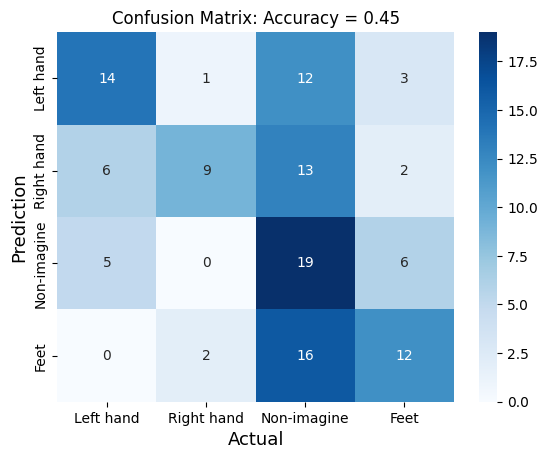

In [438]:
y_test = keras.utils.to_categorical(labels -6 , num_classes)
y_true = np.argmax(y_test, axis=1)
confusion_mat = confusion_matrix(y_true, y_pred)
loss, accuracy = pretrained_model.evaluate(train_cwt_stack, y_test)

class_names = ['Left hand', 'Right hand',  'Non-imagine', 'Feet']

sns.heatmap(confusion_mat, 
            annot=True,
            fmt='d', 
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title("Confusion Matrix: Accuracy = "+ str(round(accuracy,3)))
plt.show()

In [439]:
y_pred_raw

array([[0.181660, 0.020427, 0.741170, 0.056743],
       [0.042254, 0.047822, 0.865070, 0.044854],
       [0.359580, 0.436598, 0.130333, 0.073489],
       [0.367095, 0.011330, 0.391331, 0.230243],
       [0.039667, 0.052786, 0.055465, 0.852082],
       [0.005350, 0.077005, 0.228460, 0.689185],
       [0.336141, 0.336440, 0.271338, 0.056081],
       [0.092400, 0.243686, 0.078304, 0.585610],
       [0.108706, 0.012949, 0.776341, 0.102004],
       [0.036438, 0.039879, 0.369651, 0.554033],
       [0.097411, 0.815284, 0.070683, 0.016622],
       [0.326902, 0.050799, 0.211581, 0.410718],
       [0.077693, 0.012994, 0.317793, 0.591520],
       [0.005985, 0.014322, 0.282376, 0.697317],
       [0.681202, 0.057516, 0.253185, 0.008097],
       [0.249095, 0.185058, 0.374984, 0.190863],
       [0.104463, 0.373274, 0.272259, 0.250003],
       [0.028376, 0.006605, 0.407188, 0.557830],
       [0.644238, 0.033479, 0.234922, 0.087361],
       [0.862107, 0.013688, 0.019170, 0.105035],
       [0.636036, 0.

Note of y_pred classes :
    0 = Left,
    1 = Right,
    2 = Non-imagine,
    3 = Feet 

In [440]:
y_pred

array([2, 2, 1, 2, 3, 3, 1, 3, 2, 3, 1, 3, 3, 3, 0, 2, 1, 3, 0, 0, 0, 2,
       3, 0, 2, 2, 0, 2, 3, 2, 2, 0, 2, 2, 2, 0, 2, 2, 3, 3, 0, 3, 2, 2,
       2, 3, 0, 2, 2, 3, 1, 2, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 1, 0, 0, 2, 0, 3,
       0, 2, 2, 2, 0, 3, 2, 3, 2, 3, 1, 0, 0, 3, 1, 2, 2, 2, 2, 2, 2, 3,
       1, 0, 2, 2, 2, 2, 2, 2, 3, 0], dtype=int64)

In [441]:
combine_epochs

Number of events,610
Events,OVTK_GDF_Cross_On_Screen: 7OVTK_GDF_End_Of_Session: 1OVTK_GDF_End_Of_Trial: 120OVTK_GDF_Feedback_Continuous: 120OVTK_GDF_Incorrect: 1OVTK_GDF_Left: 30OVTK_GDF_Right: 30OVTK_GDF_Start_Of_Trial: 120OVTK_GDF_Tongue: 30OVTK_GDF_Up: 30OVTK_StimulationId_BaselineStart: 1OVTK_StimulationId_Beep: 120OVTK_StimulationId_ExperimentStart: 0OVTK_StimulationId_Train: 0
Time range,0.100 – 2.100 s
Baseline,-2.000 – 0.000 s


In [442]:
result_array = y_pred[y_pred == 2]
print('non-imagine TRUE: ', len(result_array) / 120 * 100)

non-imagine TRUE:  50.0
